In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/CNRS/TimeVAE/

[Errno 2] No such file or directory: 'drive/MyDrive/CNRS/TimeVAE/'
/content/drive/MyDrive/CNRS/TimeVAE


In [ ]:
!pip install tensorflow_privacy

In [ ]:
import sys
import numpy as np , pandas as pd
import time
import timeit
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from data_loading import real_data_loading, sine_data_generation

from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, Reshape, Conv1DTranspose ,BatchNormalization
import tensorflow as tf

import tensorflow_privacy
from tensorflow_privacy.privacy.optimizers import dp_optimizer


from timeit import default_timer as timer



In [ ]:
# Parameter definitions

param = {}

param['data_name'] = 'energy'            # sine, stocks, energy    

# choose model
vae_type = 'vae_conv'           # vae_dense, vae_conv, timeVAE

param['seq_len'] = 50
param['valid_perc'] = 0.2

param['latent_dim'] = 8
param['hidden_layer_sizes'] = [200, 100]  #[50, 100, 200] for timeVAE
param['batch_norm_enc'] = False
param['batch_norm_dec'] = False
param["reconstruction_wt"] = 3.0


param['batch_size'] = 128
param['epochs'] = 2
param['with_rec_loss'] = 12.0

param['l2_norm_clip'] = 1.5
param['noise_multiplier'] = 0.1
param['num_microbatches'] = 128
param['learning_rate'] = 0.01

param['optimizer'] =  dp_optimizer.DPAdamGaussianOptimizer(
    l2_norm_clip = param['l2_norm_clip'],
    noise_multiplier = param['noise_multiplier'],
    num_microbatches = param['num_microbatches'] ,
    learning_rate = param['learning_rate'])



In [ ]:
## Data loading
# returns shuffle np array dataset

if param['data_name'] in ['stock', 'energy']:
    full_train_data = real_data_loading(param['data_name'], param['seq_len'])
elif param['data_name'] == 'sine':
# Set number of samples and its dimensions
    no, dim = 10000, 6
    full_train_data = sine_data_generation(no, param['seq_len'], dim)

param['dataset_shape'] = full_train_data.shape


print('Dataset loaded - shape:', full_train_data.shape)

Dataset loaded - shape: (19685, 50, 28)


In [ ]:
## Train/Test split
train_data, valid_data =  train_test_split(full_train_data,test_size=param['valid_perc'])

print("train data shape:", train_data.shape)
print("validation data shape:",valid_data.shape)

train data shape: (15748, 50, 28)
validation data shape: (3937, 50, 28)


In [ ]:
# min max scale the data   
# 
scaled_train_data = np.zeros(shape=train_data.shape)
scaled_valid_data = np.zeros(shape=valid_data.shape)

# define scaler
scalers = []

# scale training data and save scalers for each dimension
for i in range(train_data.shape[1]):
    scalers.append(MinMaxScaler())
    scaled_train_data[:, i, :] = scalers[i].fit_transform(train_data[:, i, :]) 

# scale validation data
for i in range(valid_data.shape[1]):
    scaled_valid_data[:, i, :] = scalers[i].transform(valid_data[:, i, :]) 

print("Scaling performed succesfully")

Scaling performed succesfully


In [ ]:
## Convert to TFDS dataset

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices(scaled_train_data)
training_dataset = training_dataset.batch(param['batch_size'],drop_remainder=True)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices(scaled_valid_data)
validation_dataset = validation_dataset.batch(param['batch_size'])


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 123
number of batches in the validation set: 31


In [ ]:
def encoder_layers(param, inputs):
    
    x = inputs

    for i, num_filters in enumerate(param['hidden_layer_sizes']):
        x = Conv1D(
                filters = num_filters, 
                kernel_size=3, 
                strides=2, 
                activation='relu', 
                padding='same',
                name=f'enc_conv_{i}')(x)
        if param['batch_norm_enc']:
            x = tf.keras.layers.BatchNormalization()(x)

    x = Flatten(name='enc_flatten')(x)

    
    mu = Dense(param['latent_dim'], name="mu")(x)
    sigma = Dense(param['latent_dim'], name="sigma")(x)

    return mu, sigma

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    mu, sigma = inputs
    batch = tf.shape(sigma)[0]
    dim = tf.shape(sigma)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon

    return  z

In [ ]:
def encoder_model(param):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """
  inputs = Input(shape=param['dataset_shape'][1:])
  mu, sigma = encoder_layers(param, inputs)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z], name="encoder")
  model.summary()
  conv_shape = model.layers[-5].output_shape
  return model, conv_shape

In [ ]:
def decoder_layers(param, conv_shape, inputs):
    """Defines the decoder layers.
    Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

    Returns:
    tensor containing the decoded output
    """
    x = inputs
    units = conv_shape[1] * conv_shape[2]

    x = Dense(units, name="dec_dense", activation='relu')(x)
    x = Reshape((conv_shape[1], conv_shape[2]), name="decode_reshape")(x)

    for i, num_filters in enumerate(reversed(param['hidden_layer_sizes'][:-1])):
        x = Conv1DTranspose(
            filters = num_filters, 
                kernel_size=3, 
                strides=2, 
                padding='same',
                output_padding = 0,
                activation='relu', 
                name=f'dec_deconv_{i}')(x)
        if param['batch_norm_enc']:
            x = BatchNormalization()(x)

    # last de-convolution
    x = Conv1DTranspose(
            filters = param['dataset_shape'][-1], 
                kernel_size=3, 
                strides=2, 
                padding='same',
                output_padding = None,
                activation='relu', 
                name=f'dec_deconv__{i+1}')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    return x   



In [ ]:
def decoder_model(param, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """
  inputs = tf.keras.layers.Input(shape=param['latent_dim'],)
  outputs = decoder_layers(param, conv_shape, inputs)
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name="decoder")
  model.summary()
  return model

In [ ]:
def vae_model(param, encoder, decoder):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """
  inputs = tf.keras.layers.Input(shape=param['dataset_shape'][1:])

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)

  # get reconstructed output from the encoder
  reconstructed = decoder(z)

  # define the inputs and outputs to the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed, name="VAE")

  # add the KL loss
  kl_loss = (-0.5 * tf.reduce_mean(sigma - tf.square(mu) - tf.exp(sigma) + 1, axis=1)) * param['reconstruction_wt']

  model.add_loss(kl_loss)
  
  print(sigma)

  model.summary()
  return model

In [ ]:
def get_models(param):
  """Returns the encoder, decoder, and vae models"""

  encoder, conv_shape = encoder_model(param)
  decoder = decoder_model(param, conv_shape)
  vae = vae_model(param, encoder, decoder)

  return encoder, decoder, vae

In [ ]:
encoder, decoder, vae = get_models(param)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 28)]     0           []                               
                                                                                                  
 enc_conv_0 (Conv1D)            (None, 25, 200)      17000       ['input_1[0][0]']                
                                                                                                  
 enc_conv_1 (Conv1D)            (None, 13, 100)      60100       ['enc_conv_0[0][0]']             
                                                                                                  
 enc_flatten (Flatten)          (None, 1300)         0           ['enc_conv_1[0][0]']             
                                                                                            

In [ ]:
def print_during_epoch(step, nb_batch_train, train_loss_total_metric, train_loss_mse_metric, train_loss_reco_metric):
    if False:#step == :
        print(
            'Epoch: {} Total train loss:{} MSE train loss:{} Reconst train loss:{}'.format(
                epoch,
                round(train_loss_total_metric.result().numpy(),2),
                round(train_loss_mse_metric.result().numpy(),2),
                round(train_loss_reco_metric.result().numpy(),2)
                ),
            "[" + int(step/nb_batch_train*60)*"#" + (60-int(step/nb_batch_train*60))*" "+"]"
      )
    else:
        print(
            'Epoch: {} Total train loss:{} MSE train loss:{} Reconst train loss:{}'.format(
                epoch,
                round(train_loss_total_metric.result().numpy(),2),
                round(train_loss_mse_metric.result().numpy(),2),
                round(train_loss_reco_metric.result().numpy(),2)
                ),
            "[" + int(step/nb_batch_train*60)*"#" + (60-int(step/nb_batch_train*60))*" "+"]",
            end='\x1b[1K \r'
        )

In [ ]:
def get_losses(x, vae):
    """
    Computes/gets the losses and returns the tensors.
    """
    mse_loss = tf.keras.losses.MeanSquaredError(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

    reconstructed = vae(x)
    # Compute reconstruction loss
    flatten_inputs = tf.reshape(x, shape=[-1])
    flatten_outputs = tf.reshape(reconstructed, shape=[-1])

    loss_mse = mse_loss(flatten_inputs, flatten_outputs)# * 12288 # (64x64x3)
    loss_reconstruction = sum(vae.losses)
    loss_total = loss_mse + loss_reconstruction

    return(loss_total, loss_mse, loss_reconstruction)

In [ ]:
class VectorMeanSquaredError(Loss):
    def __init__(self):
        super(VectorMeanSquaredError,self).__init__(reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, 'float64')
        y_pred = tf.cast(y_pred, 'float64')

        error = y_true - y_pred
        squared_error = tf.math.square(error)
        reduced_sq_er = tf.math.reduce_mean(squared_error, axis= [-2,-1])
        return reduced_sq_er

        # error 
        # squared_error = tf.math.square(error)
        # mean_squared_error_per_line = tf.math.reduce_mean(squared_error, axis=1)
        # return mean_squared_error_per_line 

In [ ]:
def get_losses_vect(x, vae):
    """
    Computes/gets the losses and returns the tensors.
    """
    mse_loss = VectorMeanSquaredError()

    reconstructed = vae(x)
    # Fetch reconstruction loss from model
    loss_reconstruction = tf.cast(vae.losses[0] ,tf.float32)  
    # Compute reconstruction loss
    loss_mse = tf.cast(mse_loss(x, reconstructed),tf.float32)
    # Compute total loss
    loss_total = loss_mse + loss_reconstruction
    
    return(loss_total, loss_mse, loss_reconstruction)

In [ ]:
def apply_gradient(optimizer,vae,x):
    """
    Gets the gradients on the losses and applies it to the model.
    returns the value of the loss.
    """
    with tf.GradientTape() as tape:
        loss_total, loss_mse, loss_reconstruction = get_losses(x, vae)
    
    grads = tape.gradient(loss_total, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    return(loss_total.numpy(), loss_mse.numpy(), loss_reconstruction.numpy())

In [ ]:
def apply_gradient_vect(optimizer,vae,x):
    """
    Gets the gradients on the losses and applies it to the model.
    returns the value of the loss.
    """
    


    with tf.GradientTape() as tape:
        loss_total, loss_mse, loss_reconstruction = get_losses_vect(x, vae)

        def loss_fn():
            return loss_total

    # grads = tape.gradient(loss_total, vae.trainable_weights)
        grads_and_vars  = optimizer.compute_gradients(loss_fn, vae.trainable_weights, gradient_tape=tape)
    optimizer.apply_gradients(grads_and_vars)

    return(loss_total.numpy().mean(), loss_mse.numpy().mean(), loss_reconstruction.numpy().mean())

In [ ]:
def train_one_epoch(param,training_dataset,vae):
    """
    Performs one training epochs and collects the loss values
    """
    total_losses = []
    mse_losses = []
    reconstruction_losses = []
    # adapt for 3 losses values
    for step, batch in enumerate(training_dataset):
        
        loss_total, loss_mse, loss_reconstruction = apply_gradient_vect(
            param['optimizer'],
            vae,
            batch)
        
        total_losses.append(loss_total)
        mse_losses.append(loss_mse)
        reconstruction_losses.append(loss_reconstruction)

    mean_total_losses = np.array(total_losses).mean()
    mean_mse_losses = np.array(mse_losses).mean()
    mean_reconstruction_losses = np.array(reconstruction_losses).mean()

    return mean_total_losses, mean_mse_losses, mean_reconstruction_losses

In [ ]:
def perform_validation(validation_dataset,vae):

    total_losses = []
    mse_losses = []
    reconstruction_losses = []

    for step, batch in enumerate(validation_dataset):

        loss_total, loss_mse, loss_reconstruction = get_losses(batch, vae)

        #convert to numpy
        total_losses.append(loss_total.numpy())
        mse_losses.append(loss_mse.numpy())
        reconstruction_losses.append(loss_reconstruction.numpy())

    mean_total_losses = np.array(total_losses).mean()
    mean_mse_losses = np.array(mse_losses).mean()
    mean_reconstruction_losses = np.array(reconstruction_losses).mean()

    return mean_total_losses, mean_mse_losses, mean_reconstruction_losses

In [ ]:
def perform_validation_vect(validation_dataset,vae):

    total_losses = []
    mse_losses = []
    reconstruction_losses = []

    for step, batch in enumerate(validation_dataset):

        loss_total, loss_mse, loss_reconstruction = get_losses_vect(batch, vae)

        #convert to numpy
        total_losses.append(loss_total.numpy().mean())
        mse_losses.append(loss_mse.numpy().mean())
        reconstruction_losses.append(loss_reconstruction.numpy().mean())

    mean_total_losses = np.array(total_losses).mean()
    mean_mse_losses = np.array(mse_losses).mean()
    mean_reconstruction_losses = np.array(reconstruction_losses).mean()

    return mean_total_losses, mean_mse_losses, mean_reconstruction_losses

In [ ]:
optimizer = param['optimizer']
epochs = param['epochs']
wr = param["reconstruction_wt"]
nb_batch_train = len(training_dataset)

history = {
  'valid_loss':[],
  'valid_loss_reco':[],
  'valid_loss_mse':[],
  'train_loss':[],
  'train_loss_reco':[], 
  'train_loss_mse':[]
  }

random_vector_for_generation = tf.random.normal(shape=(param["latent_dim"],))
# generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

TO DO
 - add model saving at given epochs 
 - generate data

In [ ]:
for epoch in range(1,epochs+1):
  print('Start of epoch %d' % (epoch,), end='\x1b[1K \r')
  start = timer()

  mean_train_total_losses, mean_train_mse_losses, mean_train_reconstruction_losses = train_one_epoch(param,training_dataset,vae)
  mean_val_total_losses, mean_val_mse_losses, mean_val_reconstruction_losses = perform_validation_vect(validation_dataset,vae)

  end = timer()

  print(
    f"Epoch {epoch} duration : {np.around(end-start,2)}s, TRAIN total:{round(float(mean_train_total_losses),2)} "+
    f"mse:{round(float(mean_train_mse_losses),2)} reco:{round(float(mean_train_reconstruction_losses),2)}, VALID to"+
    f"tal:{round(float(mean_val_total_losses),2)} mse:{round(float(mean_val_mse_losses),2)} reco:{round(float(mean_val_reconstruction_losses),2)}")


Epoch 1 duration : 41.4s, TRAIN total:0.55 mse:0.42 reco:0.13, VALID total:0.5 mse:0.41 reco:0.09
Epoch 2 duration : 24.54s, TRAIN total:0.47 mse:0.39 reco:0.08, VALID total:0.49 mse:0.39 reco:0.1


In [ ]:
    early_stop_callback = EarlyStopping(monitor='loss', min_delta = 1e-1, patience=10) 
    reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)

    # log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
tensorflow_privacy.compute_dp_sgd_privacy(
    n=9000,
    batch_size = 32,
    noise_multiplier = 0.1,
    epochs = 10,
    delta = 1e-5
)

DP-SGD with sampling rate = 0.356% and noise_multiplier = 0.1 iterated over 2813 steps satisfies differential privacy with eps = 9.65e+04 and delta = 1e-05.
The optimal RDP order is 1.25.
The privacy estimate is likely to be improved by expanding the set of orders.


(96542.19585216264, 1.25)

In [ ]:
model_dir = './model/'
file_pref = f'vae_{vae_type}_{dataset}_perc_{perc_of_train_used}_iter_{0}_latdim_{latent_dim}_'
vae.save(model_dir, file_pref)

visually check reconstruction

In [ ]:
X = scaled_train_data

x_decoded = vae.predict(scaled_train_data)
print('x_decoded.shape', x_decoded.shape)

282/282 [==============================] - 10s 13ms/step
x_decoded.shape (9000, 24, 5)


compare original and posterior predictive (reconstructed) samples


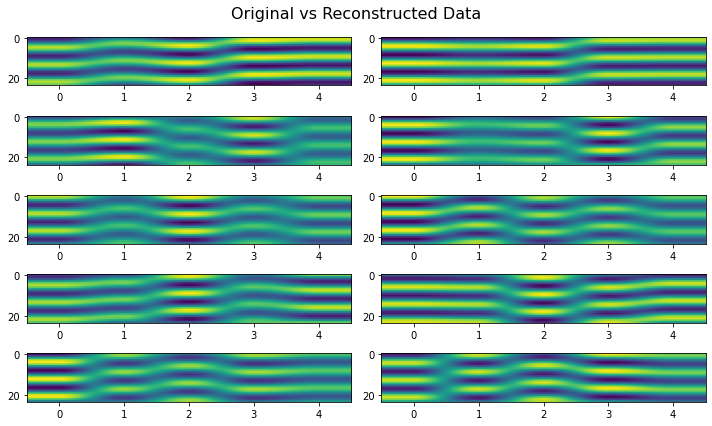

In [ ]:
utils.draw_orig_and_post_pred_sample(X, x_decoded, n=5)

282/282 [==============================] - 6s 10ms/step


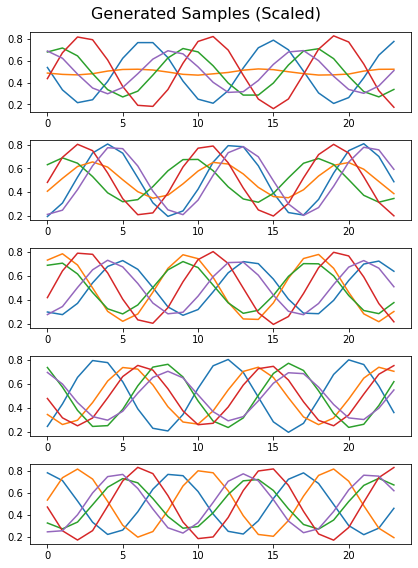

In [ ]:
    # draw random prior samples
    num_samples = N_train
    # print("num_samples: ", num_samples)

    samples = vae.get_prior_samples(num_samples=num_samples)
    
    utils.plot_samples(samples, n=5)

inverse-transform scaling and save

In [ ]:
samples = scaler.inverse_transform(samples)
print('shape of gen samples: ', samples.shape) 

# output_dir = './outputs/'
# sample_fname = f'{vae_type}_gen_samples_{dataset}_perc_{perc_of_train_used}.npz' 
# samples_fpath = os.path.join(output_dir, sample_fname) 
# np.savez_compressed(samples_fpath, data=samples)

shape of gen samples:  (9000, 24, 5)
